# Transfer Learning Multi-Class Classification

This notebook contains the pipeline that allows to perform classification experiments of the Multi-Class version of this problem. **Cardboard**, **Metal**, **Paper**, **Glass**, and **Plastic** are the classes that are considered in this set of experiments. The used <u>data set</u> may be found in the following [Kaggle Repository](https://www.kaggle.com/asdasdasasdas/garbage-classification). 

NN_experimentation_notebook.ipynb set the baseline in order to work with in this notebook, the binary classification version of the problem is worked in there. In case of doubts, this should be the reference to be consulted.

# Imports

In [1]:
%%capture
# Import helper functions
!wget https://raw.githubusercontent.com/daoterog/Solid_Domestic_Waste_Image_Classification/main/helper_functions/file_management.py
!wget https://raw.githubusercontent.com/daoterog/Solid_Domestic_Waste_Image_Classification/main/helper_functions/evaluation_functions.py
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [13]:
import os
import errno
import tensorflow as tf

# Helper functions
from helper_functions import create_tensorboard_callback, walk_through_dir
from file_management import bring_data, split_images, copy_folder
from evaluation_functions import (plot_loss_curves, compare_historys, 
                                  evaluate_NN, print_most_wrong_prediction)
                                  

from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


# Preprocessing

## Load the Data

In [3]:
path_list = ['/content/drive/MyDrive/PI2/data/cardboard.zip',
            '/content/drive/MyDrive/PI2/data/metal.zip',
             '/content/drive/MyDrive/PI2/data/glass.zip',
             '/content/drive/MyDrive/PI2/data/paper.zip',
             '/content/drive/MyDrive/PI2/data/plastic.zip']

# Unzip the data
bring_data(path_list=path_list)

# Split the dataset into train and test subsets
split_images(train_size=0.7, test_proportion=0.5)

# How many images/classes are there?
walk_through_dir("data")

Not found
Not found
There are 8 directories and 0 images in 'data'.
There are 0 directories and 482 images in 'data/plastic'.
There are 0 directories and 403 images in 'data/cardboard'.
There are 0 directories and 410 images in 'data/metal'.
There are 0 directories and 501 images in 'data/glass'.
There are 5 directories and 0 images in 'data/test'.
There are 0 directories and 141 images in 'data/test/plastic'.
There are 0 directories and 120 images in 'data/test/cardboard'.
There are 0 directories and 115 images in 'data/test/metal'.
There are 0 directories and 148 images in 'data/test/glass'.
There are 0 directories and 171 images in 'data/test/paper'.
There are 5 directories and 0 images in 'data/train'.
There are 0 directories and 248 images in 'data/train/plastic'.
There are 0 directories and 203 images in 'data/train/cardboard'.
There are 0 directories and 213 images in 'data/train/metal'.
There are 0 directories and 249 images in 'data/train/glass'.
There are 0 directories and 29

In [4]:
# Image paths
train_dir = '/content/data/train'
validation_dir = '/content/data/validation'
test_dir =  '/content/data/test'

IMG_SIZE = (224,224)
BATCH_SIZE = 32

# Load in the data
train_data = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                         label_mode='categorical',
                                                         image_size=IMG_SIZE,
                                                         batch_size=BATCH_SIZE,
                                                         shuffle=False)

validation_data = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                         label_mode='categorical',
                                                         image_size=IMG_SIZE,
                                                         batch_size=BATCH_SIZE,
                                                         shuffle=False)

test_data = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                         label_mode='categorical',
                                                         image_size=IMG_SIZE,
                                                         batch_size=BATCH_SIZE,
                                                         shuffle=False)

Found 1211 files belonging to 5 classes.
Found 484 files belonging to 5 classes.
Found 695 files belonging to 5 classes.


## Define Early Stopping Callback

In [5]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                 patience=10)

## Define Data Augmentation Layer

In [6]:
# Create a Data Augmentation Layer
data_augmentation = tf.keras.Sequential([
    # preprocessing.RandomCrop(height=0.2,width=0.3), # Don't works for some reason
    tf.keras.layers.RandomFlip(mode='horizontal'),
    tf.keras.layers.RandomFlip(mode='vertical'),
    # preprocessing.RandomHeight(0.2),
    tf.keras.layers.RandomRotation(0.3),
    tf.keras.layers.RandomTranslation(0.3,0.3),
    # preprocessing.RandomWidth(0.2),
    # preprocessing.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.3),
    # layers.Rescaling(255.),
    tf.keras.layers.Resizing(224,224)
], name='data_augmentation_layer')

# Models

## Feature Extraction

In [7]:
# Create Feature Extraction Model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Define inputs
inputs = tf.keras.layers.Input(shape=IMG_SIZE + (3,), name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(len(train_data.class_names), activation='softmax', 
                       name='output_layer')(x)

# Build Model
feature_extraction_model = tf.keras.Model(inputs, outputs)

# Get summary
feature_extraction_model.summary()

16719872/16705208 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation_layer (Seq (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 5)                 6405      
Total params: 4,055,976
Trainable params: 6,405
Non-trainable params: 4,049,571
_________________________________________________________________


In [8]:
# Compile the model
feature_extraction_model.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit it
feature_extraction_model_history = feature_extraction_model.fit(
    train_data, epochs=50, validation_data=validation_data, 
    callbacks=[earlystopping, create_tensorboard_callback(
        dir_name='research_practice',
        experiment_name='feature_extraction_model'
    )]
)

Saving TensorBoard log files to: research_practice/feature_extraction_model/20211102-020857


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/50
38/38 [==============================] - 46s 285ms/step - loss: 2.3108 - accuracy: 0.1718 - val_loss: 1.1619 - val_accuracy: 0.6260
Epoch 2/50
38/38 [==============================] - 8s 202ms/step - loss: 1.1375 - accuracy: 0.5524 - val_loss: 0.7681 - val_accuracy: 0.7211
Epoch 3/50
38/38 [==============================] - 8s 202ms/step - loss: 1.0513 - accuracy: 0.5392 - val_loss: 0.6055 - val_accuracy: 0.7913
Epoch 4/50
38/38 [==============================] - 8s 204ms/step - loss: 0.9328 - accuracy: 0.6086 - val_loss: 0.5319 - val_accuracy: 0.8058
Epoch 5/50
38/38 [==============================] - 8s 204ms/step - loss: 0.7832 - accuracy: 0.6895 - val_loss: 0.4780 - val_accuracy: 0.8347
Epoch 6/50
38/38 [==============================] - 8s 201ms/step - loss: 0.7604 - accuracy: 0.7019 - val_loss: 0.4488 - val_accuracy: 0.8471
Epoch 7/50
38/38 [==============================] - 8s 202ms/step - loss: 0.6952 - accuracy: 0.7391 - val_loss: 0.4219 - val_accuracy: 0.8574
Epoch

In [9]:
# Evaluate Model
feature_extraction_model_results = feature_extraction_model.evaluate(test_data)
feature_extraction_model_results

22/22 [==============================] - 4s 161ms/step - loss: 0.3373 - accuracy: 0.8806


[0.337271124124527, 0.8805755376815796]

## Fine Tunning

In [16]:
# Let's unfreeze some layers of the base_model
NUM_UNFROZEN_LAYERS = 5

base_model.trainable = True
for layer in feature_extraction_model.layers[2].layers[:-NUM_UNFROZEN_LAYERS]:
    layer.trainable = False

fine_tuning_model = feature_extraction_model

In [17]:
# Compile the model
fine_tuning_model.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                metrics=['accuracy'])

# Fit it
fine_tuning_epochs = 20

fine_tuning_model_history = fine_tuning_model.fit(
    train_data, epochs=50 + fine_tuning_epochs, validation_data=validation_data, 
    initial_epoch=feature_extraction_model_history.epoch[-1],
    callbacks=[earlystopping, create_tensorboard_callback(
        dir_name='research_practice',
        experiment_name='fine_tuning_model'
    )]
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Saving TensorBoard log files to: research_practice/fine_tuning_model/20211102-021819
Epoch 50/70


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


38/38 [==============================] - 19s 280ms/step - loss: 0.6212 - accuracy: 0.7564 - val_loss: 0.3574 - val_accuracy: 0.8781
Epoch 51/70
38/38 [==============================] - 8s 209ms/step - loss: 0.4906 - accuracy: 0.8026 - val_loss: 0.2793 - val_accuracy: 0.9132
Epoch 52/70
38/38 [==============================] - 8s 210ms/step - loss: 0.3194 - accuracy: 0.8869 - val_loss: 0.2666 - val_accuracy: 0.9153
Epoch 53/70
38/38 [==============================] - 8s 208ms/step - loss: 0.3187 - accuracy: 0.8753 - val_loss: 0.2732 - val_accuracy: 0.9132
Epoch 54/70
38/38 [==============================] - 8s 209ms/step - loss: 0.3157 - accuracy: 0.8753 - val_loss: 0.2676 - val_accuracy: 0.9174
Epoch 55/70
38/38 [==============================] - 8s 209ms/step - loss: 0.3695 - accuracy: 0.8596 - val_loss: 0.2766 - val_accuracy: 0.9174
Epoch 56/70
38/38 [==============================] - 8s 207ms/step - loss: 0.3047 - accuracy: 0.8819 - val_loss: 0.2669 - val_accuracy: 0.9194
Epoch 57/7

In [18]:
# Evaluate the fine-tuned model
fine_tuning_model_results = fine_tuning_model.evaluate(test_data)
fine_tuning_model_results

22/22 [==============================] - 3s 133ms/step - loss: 0.3202 - accuracy: 0.9022


[0.3201799690723419, 0.902158260345459]

# Evaluating Performance

In [20]:
# Create Directory
root = 'experiments/'
destination = '/content/drive/MyDrive/PI2/experiments'

try:
    os.mkdir(root)
except OSError as e:
    if e.errno == errno.EEXIST:
        print('Directory already exist')
    else:
        raise

# Create Experiment Directory
experiment = str(input('Type Experiment Name: '))
path = root + experiment
try:
    os.mkdir(path)
except OSError as e:
    if e.errno == errno.EEXIST:
        print('Directory already exist')
    else:
        raise
model_name = str(input('Type Model Name: '))

Type Experiment Name: first_tets
Type Model Name: all


## Plot Learning curves

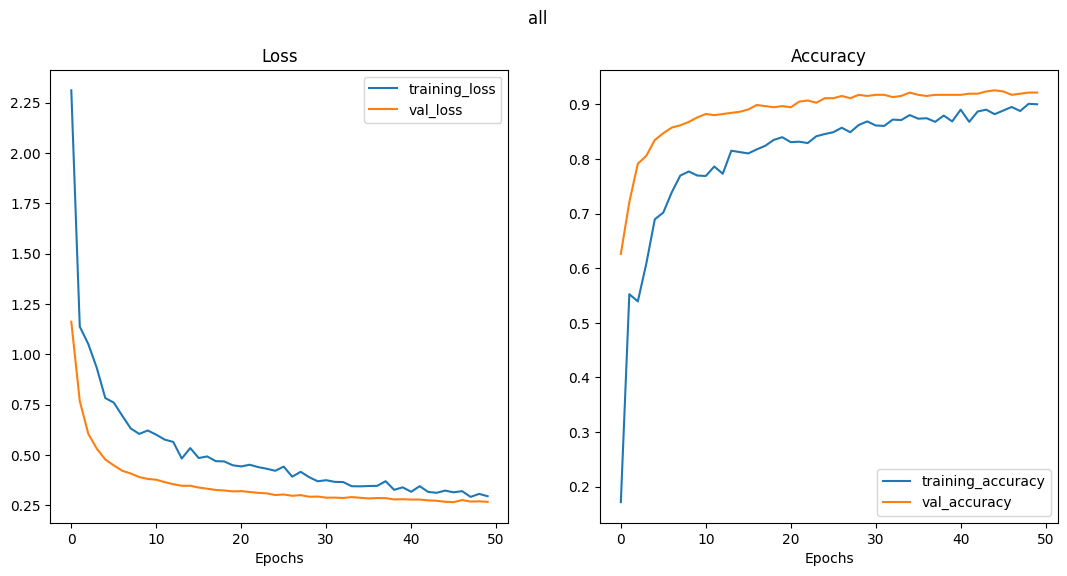

In [21]:
plot_loss_curves(feature_extraction_model_history, model_name, path)

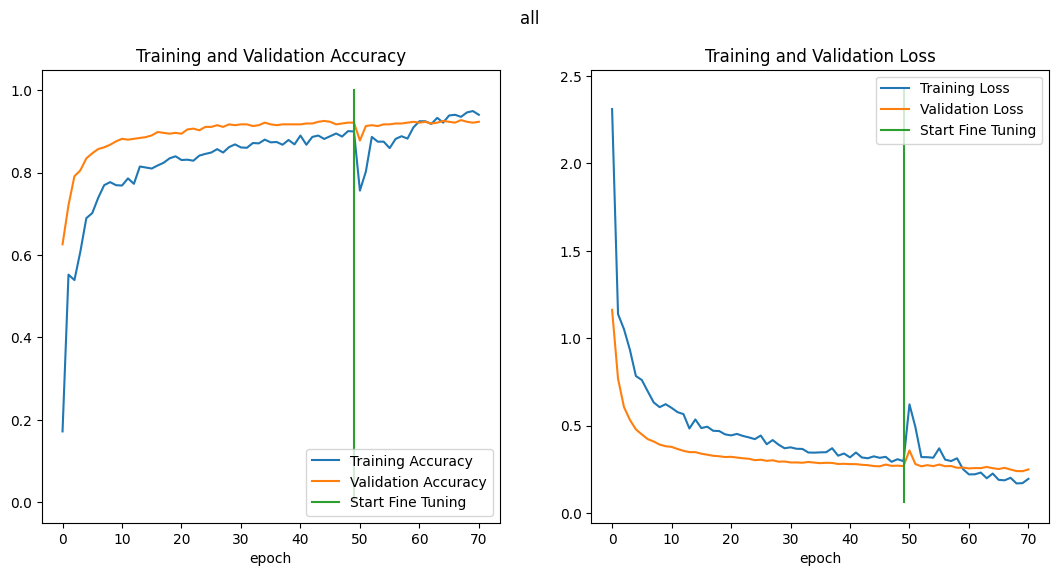

In [23]:
# Compare history
compare_historys(feature_extraction_model_history, fine_tuning_model_history, 50, 
                 model_name, path)

## Confusion Matrix and Score Barplots

22/22 [==============================] - 4s 116ms/step


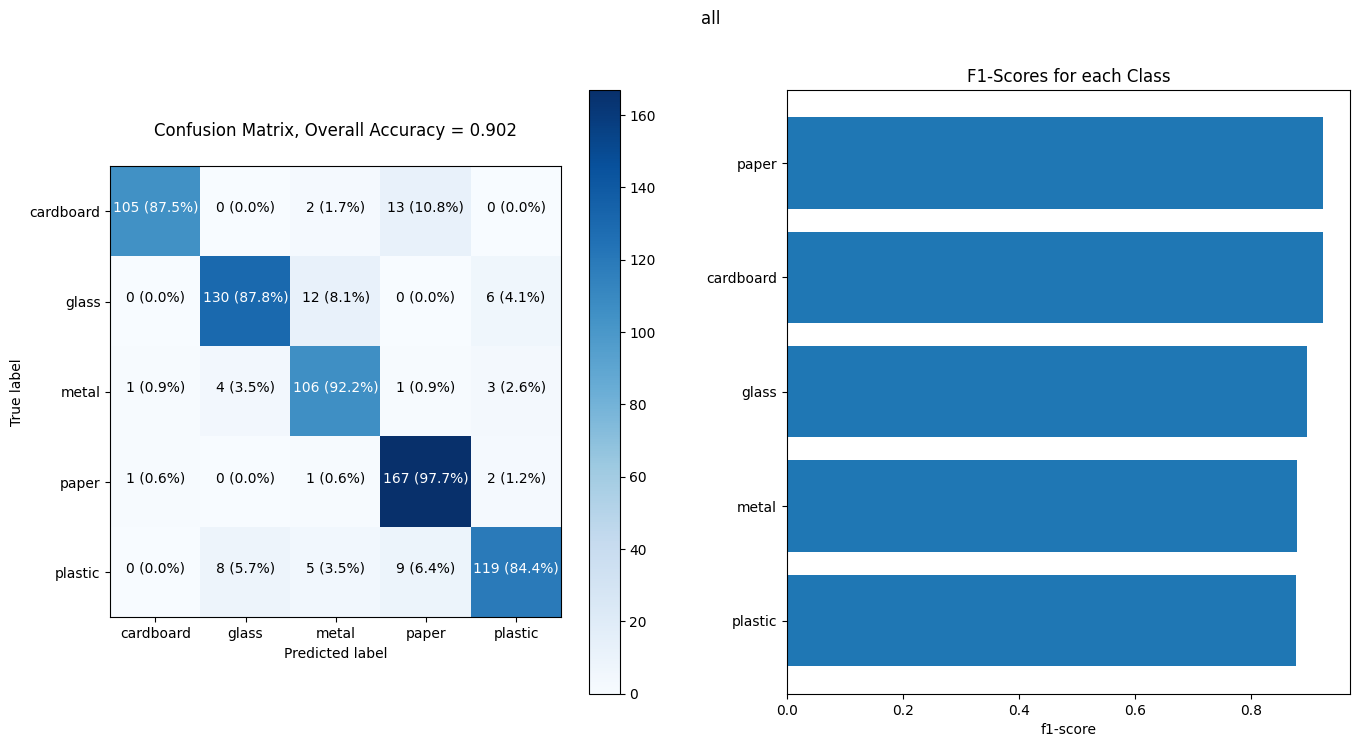

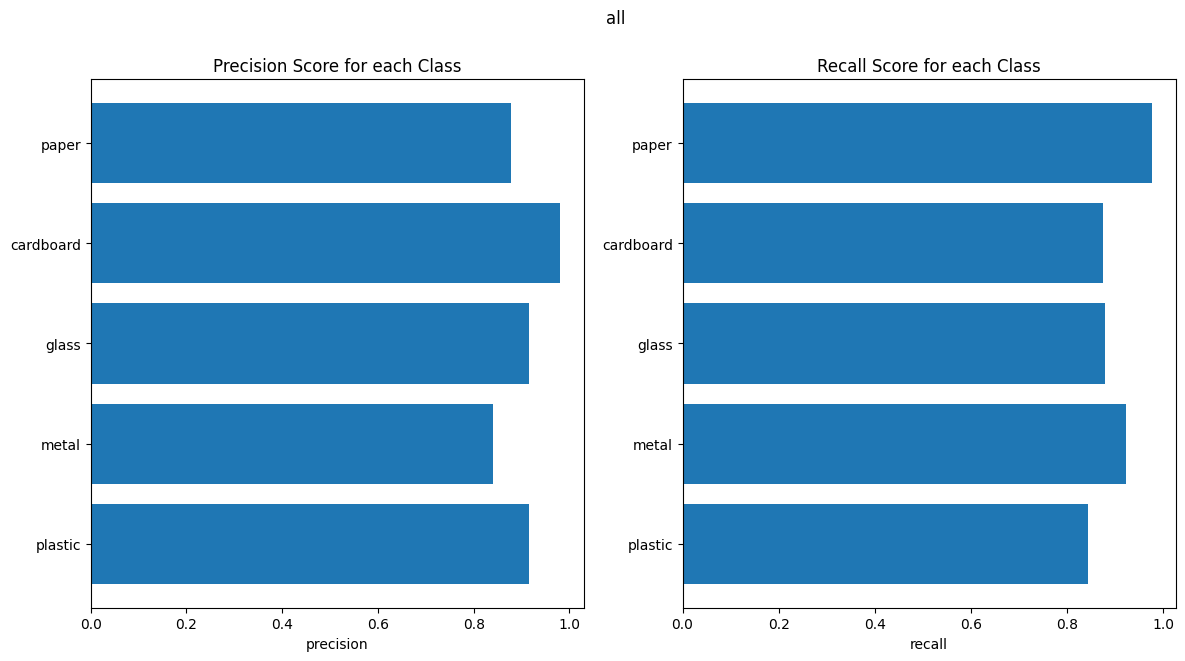

In [24]:
df_results, wrong_preds = evaluate_NN(fine_tuning_model, test_data, 
                                      model_name, path)

## Print Most Wrong Predictions

In [25]:
print_most_wrong_prediction(wrong_preds, 10)

Output hidden; open in https://colab.research.google.com to view.

# Storing Results

In [ ]:
copy_folder(path, destination)

# Upload to TensorBoard Hub

In [ ]:
!tensorboard dev list

In [ ]:
!tensorboard dev upload --logdir /content/research_practice --name "Research Practice Model Experiments" --one_shot --description "Here are stored the results of the final models resulting from my research practice II. You can check the notebook where this was generated in https://github.com/daoterog/Solid_Domestic_Waste_Image_Classification" 